#  Task - A

In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install imbalanced-learn pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install bs4

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GRU, Dense, SpatialDropout1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
binary_dataset = pd.read_csv("train_all_tasks.csv", usecols=['text', 'label_sexist'])
print(binary_dataset.head())

                                                text label_sexist
0              Damn, this writing was pretty chaotic   not sexist
1  Yeah, and apparently a bunch of misogynistic v...   not sexist
2       How the FUCK is this woman still an MP!!!???   not sexist
3  Understand. Know you're right. At same time I ...   not sexist
4     Surprized they didn't stop and rape some women   not sexist


In [3]:
print(binary_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          14000 non-null  object
 1   label_sexist  14000 non-null  object
dtypes: object(2)
memory usage: 218.9+ KB
None


In [4]:
print(binary_dataset.describe())

                                         text label_sexist
count                                   14000        14000
unique                                  14000            2
top     Damn, this writing was pretty chaotic   not sexist
freq                                        1        10602


In [5]:
print(binary_dataset['label_sexist'].unique())

['not sexist' 'sexist']


### Encoding label_sexist column | not_sexist : 0 | sexist : 1

In [6]:
binary_dataset['label_sexist'] = binary_dataset['label_sexist'].map({'not sexist': 0, 'sexist': 1})
print(binary_dataset)

                                                    text  label_sexist
0                  Damn, this writing was pretty chaotic             0
1      Yeah, and apparently a bunch of misogynistic v...             0
2           How the FUCK is this woman still an MP!!!???             0
3      Understand. Know you're right. At same time I ...             0
4         Surprized they didn't stop and rape some women             0
...                                                  ...           ...
13995  complexes like the 'nice chicks' that go after...             1
13996  "GRAPHIC Germany - Muslim "refugee" stabbing h...             0
13997  Lol I imagine there would be simps that are li...             0
13998  It's not, the girls I go on dates with don't k...             0
13999  How can he be an incel? He does have a girlfri...             0

[14000 rows x 2 columns]


### Using wordcloud to visualize which words are associated with which class

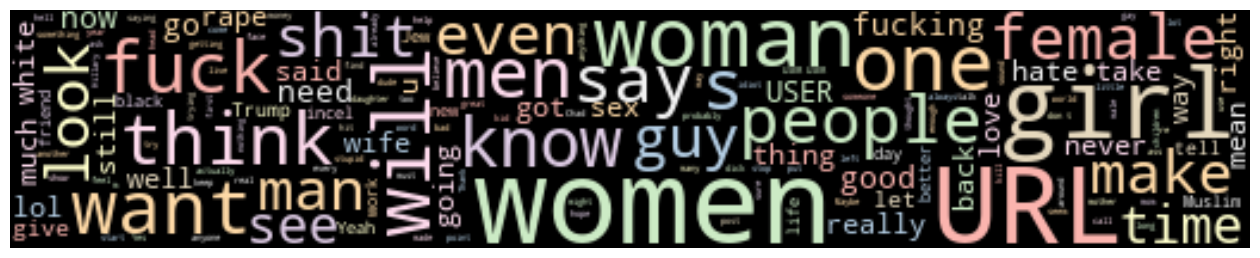

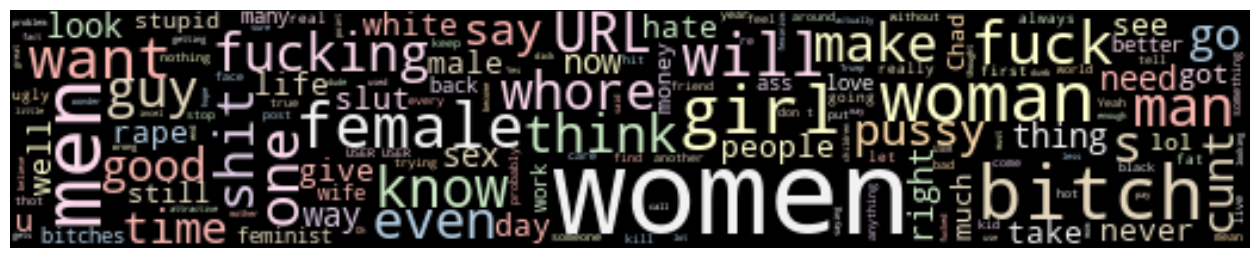

In [9]:
# Dropping all the sexist rows and convert the dataframe to a string
def convert_df_to_str(df, col_to_drop, row_label_to_drop, string_col):
    new_df = df[df[col_to_drop] == row_label_to_drop]
    new_df = new_df.drop(columns=[col_to_drop])
    new_df = ' '.join(new_df[string_col])
    return new_df

not_sexist_rows = convert_df_to_str(binary_dataset, 'label_sexist', 0, 'text')
sexist_rows = convert_df_to_str(binary_dataset, 'label_sexist', 1, 'text')

not_sexist_cloud = WordCloud(width =520, height =100, stopwords = STOPWORDS, max_font_size = 50, background_color = "black", colormap = 'Pastel1').generate(not_sexist_rows)
plt.figure(figsize=(16,10))
plt.imshow(not_sexist_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.savefig(f"not_sexist_cloud")
plt.show()

sexist_cloud = WordCloud(width =520, height =100, stopwords = STOPWORDS, max_font_size = 50, background_color = "black", colormap = 'Pastel1').generate(sexist_rows)
plt.figure(figsize=(16,10))
plt.imshow(sexist_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.savefig(f"sexist_cloud")
plt.show()

### Balancing the dataset using Oversampling, Undersampling, SMOTE

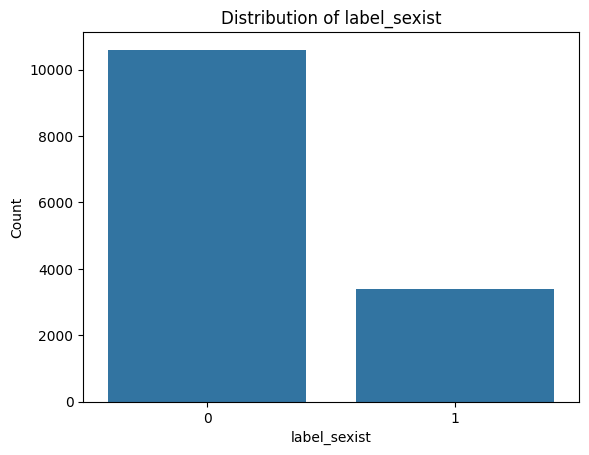

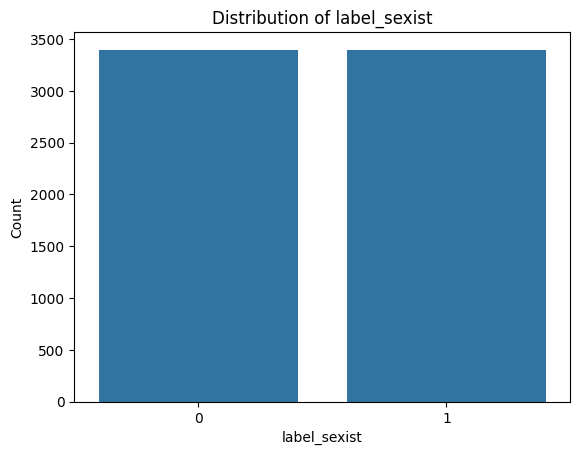

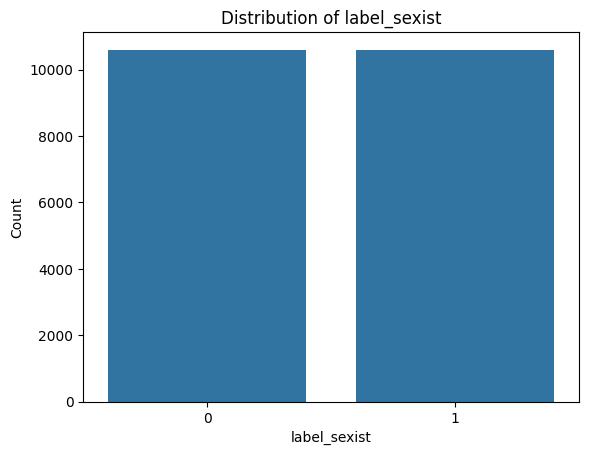

In [8]:
def sampler(df, target_variable, type):
    if type == 'undersample':
        sampler = RandomUnderSampler(random_state=42)
    else:
        sampler = RandomOverSampler(random_state=42)

    X_resampled, y_resampled = sampler.fit_resample(df.drop(columns=[target_variable]), df[target_variable])
    return pd.concat([X_resampled, y_resampled.rename('label_sexist')], axis=1)

binary_dataset_undersampled = sampler(binary_dataset, 'label_sexist', 'undersample')
binary_dataset_oversampled = sampler(binary_dataset, 'label_sexist', 'oversample')

target_variable = "label_sexist"
dataframes = [binary_dataset, binary_dataset_undersampled, binary_dataset_oversampled]
count = 0
for i in range(len(dataframes)):
    sns.countplot(data=dataframes[i], x=target_variable)
    
    # Add Labels
    plt.xlabel(target_variable)
    plt.ylabel('Count')
    plt.title(f'Distribution of {target_variable}')
    
    plt.savefig(f"class_distribution{count}.png")
    count += 1
    plt.show()

### Text Preprocessing

In [15]:
# Function to remove special characters
def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

# Function to convert text to lowercase
def to_lowercase(text):
    return text.lower()

for i in range(len(dataframes)):
    dataframes[i]['text'] = dataframes[i]['text'].apply(remove_special_characters)
    dataframes[i]['text'] = dataframes[i]['text'].apply(to_lowercase)
    print(dataframes[i])

                                                    text  label_sexist
0                   damn this writing was pretty chaotic             0
1      yeah and apparently a bunch of misogynistic vi...             0
2                 how the fuck is this woman still an mp             0
3      understand know youre right at same time i kno...             0
4          surprized they didnt stop and rape some women             0
...                                                  ...           ...
13995  complexes like the nice chicks that go after b...             1
13996  graphic germany  muslim refugee stabbing his y...             0
13997  lol i imagine there would be simps that are li...             0
13998  its not the girls i go on dates with dont kiss...             0
13999  how can he be an incel he does have a girlfrie...             0

[14000 rows x 2 columns]
                                                    text  label_sexist
3633   she is a clientfor now i just sent some of m

### Optional text preprocessing

In [16]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kaziknobo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kaziknobo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kaziknobo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
# Function to remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

# Function to perform stemming
def stem_text(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

# Function to perform lemmatization
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

# Try different combinations
for i in range(len(dataframes)):
    dataframes[i]['text'] = dataframes[i]['text'].apply(remove_stopwords)
    # dataframes[i]['text'] = dataframes[i]['text'].apply(stem_text)
    dataframes[i]['text'] = dataframes[i]['text'].apply(lemmatize_text)

    print(dataframes[i])

                                                    text  label_sexist
0                              damn write pretti chaotic             0
1      yeah appar bunch misogynist virgin one turn ga...             0
2                                    fuck woman still mp             0
3      understand know right time know isnt enough mo...             0
4                          surpriz didnt stop rape woman             0
...                                                  ...           ...
13995  complex like nice chick go bad boy nah nah nah...             1
13996  graphic germani muslim refuge stab younger yo ...             0
13997  lol imagin would simp like doesnt deserv ugli ...             0
13998  girl go date dont kiss first date dont text ba...             0
13999  incel girlfriend fuck anyon say kiss legit gir...             0

[14000 rows x 2 columns]
                                                    text  label_sexist
3633                       clientfor sent jew clien

### Splitting the Dataset

In [18]:
# Imbalanced processed dataset
X = dataframes[0]['text']
y = dataframes[0]['label_sexist']

# Undersampled processed dataset
X_under = dataframes[1]['text']
y_under = dataframes[1]['label_sexist']

# Oversampled preprocessed dataset
X_over = dataframes[2]['text']
y_over = dataframes[2]['label_sexist']

# Try combinations
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("Training set - X:", X_train.shape, " y:", y_train.shape)
print("Testing set - X:", X_test.shape, " y:", y_test.shape)

Training set - X: (16963,)  y: (16963,)
Testing set - X: (4241,)  y: (4241,)


### Tokenize, convert each sentences to sequence of tokens, pad the sequences for the neural network model

In [19]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
num_words = len(word_index) + 1

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)


train_padded = pad_sequences(train_sequences, padding='post', truncating='post')
max_len = train_padded[0].shape[0]
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

### Creating the embedding matrix using Glove

### For glove please use glove.6B.100d.txt file | Download link: https://nlp.stanford.edu/data/glove.6B.zip

In [20]:
def create_embedding_hash(file_path):
    embedding_hash = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embedding_hash[word] = vector

    return embedding_hash

def create_embedding_matrix(embedding_hash, embedding_matrix, word_index):
    for word, i in word_index.items():
        embedding_vector = embedding_hash.get(word)
        
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

embedding_hash = create_embedding_hash('glove.6B.100d.txt')

embedding_dim = 100
embedding_matrix = np.zeros((num_words, embedding_dim))
embedding_matrix = create_embedding_matrix(embedding_hash, embedding_matrix, word_index)

### Building the neural network models

In [21]:
# Create LSTM model
def create_lstm_model(embedding_matrix, max_len):
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=max_len, trainable=False))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128))  # Adjust the units as needed
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Adjust activation function for your task
    return model

# Create Bi-LSTM model
def create_bilstm_model(embedding_matrix, max_len):
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=max_len, trainable=False))
    model.add(Bidirectional(LSTM(128)))  # Adjust the units as needed
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Adjust activation function for your task
    return model

# Create GRU model
def create_gru_model(embedding_matrix, max_len):
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=max_len, trainable=False))
    model.add(SpatialDropout1D(0.2))
    model.add(GRU(128))  # Adjust the units as needed
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Adjust activation function for your task
    return model

# Compile the models
def compile_model(model):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Adjust loss and metrics for your task

# Assuming you have already loaded your pre-trained GloVe embeddings into the embedding_matrix variable

# Create LSTM model
lstm = create_lstm_model(embedding_matrix, max_len)
compile_model(lstm)

# Create Bi-LSTM model
bilstm = create_bilstm_model(embedding_matrix, max_len)
compile_model(bilstm)

# Create GRU model
gru = create_gru_model(embedding_matrix, max_len)
compile_model(gru)

### Checking the layers and summary of the model

In [22]:
print(lstm.summary())
print(bilstm.summary())
print(gru.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 100)           1452900   
                                                                 
 spatial_dropout1d (Spatial  (None, 33, 100)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1570277 (5.99 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 1452900 (5.54 MB)
_____________

### Training the models

In [30]:
def train_evaluate(num_epoch, batch_size, early_stop, model, train_padded, y_train, test_padded, y_test):
    model_history = model.fit(train_padded, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, callbacks = [early_stop], verbose=True)
    
    loss, accuracy = model.evaluate( train_padded, y_train, verbose = False )
    print( "\nTraining Accuracy: {:.4f}, Training Loss: {:.4f}".format(accuracy, loss) )
    loss, accuracy = model.evaluate( test_padded, y_test, verbose = False )
    print( "Testing Accuracy:  {:.4f}, Testing Loss: {:.4f}\n".format(accuracy, loss) )
    
    # Predicting y
    y_pred_prob = model.predict(test_padded)
    
    # Convert probabilities to binary predictions
    y_pred = np.where(y_pred_prob > 0.5, 1, 0)
    
    # Calculate precision
    precision = precision_score(y_test, y_pred)
    
    # Calculate recall
    recall = recall_score(y_test, y_pred)
    
    # Calculate F1 score
    f1 = f1_score(y_test, y_pred)
    
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print('\n')

num_epochs = 30
batch_size = 64
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

In [31]:
#Training and evaluation
print("---------------------LSTM---------------------")
train_evaluate(num_epochs, batch_size, early_stop, lstm, train_padded, y_train, test_padded, y_test)

print("---------------------BI-LSTM---------------------")
train_evaluate(num_epochs, batch_size, early_stop, bilstm, train_padded, y_train, test_padded, y_test)

print("---------------------GRU---------------------")
train_evaluate(num_epochs, batch_size, early_stop, gru, train_padded, y_train, test_padded, y_test)

---------------------LSTM---------------------
Epoch 1/30
239/239 [==============================] - 4s 18ms/step - loss: 0.2013 - accuracy: 0.9212 - val_loss: 0.4299 - val_accuracy: 0.8444
Epoch 2/30
239/239 [==============================] - 4s 18ms/step - loss: 0.1878 - accuracy: 0.9272 - val_loss: 0.3360 - val_accuracy: 0.8680
Epoch 3/30
239/239 [==============================] - 4s 18ms/step - loss: 0.1726 - accuracy: 0.9350 - val_loss: 0.3472 - val_accuracy: 0.8798
Epoch 4/30
239/239 [==============================] - 4s 18ms/step - loss: 0.1560 - accuracy: 0.9432 - val_loss: 0.3975 - val_accuracy: 0.8715

Training Accuracy: 0.9602, Training Loss: 0.1187
Testing Accuracy:  0.8611, Testing Loss: 0.4166

133/133 [==============================] - 1s 4ms/step
Precision: 0.8125506072874494
Recall: 0.9409282700421941
F1 Score: 0.8720399739300457


---------------------BI-LSTM---------------------
Epoch 1/30
239/239 [==============================] - 5s 21ms/step - loss: 0.5115 - accur